<a href="https://colab.research.google.com/github/Evans-tats/CodeAlpha_Emotion-Recognition-from-Speech/blob/main/Emotion_Recognition_from_Speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import IPython.display as ipd
from IPython.display import Audio

import os

In [2]:
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"evanskipsang","key":"ff66d8f0e99e93411cd7356a4a979f33"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio


Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
 79% 339M/429M [00:00<00:00, 1.18GB/s]
100% 429M/429M [00:00<00:00, 1.18GB/s]


In [ ]:
!unzip ravdess-emotional-speech-audio.zip -d ravdess_data


In [7]:
import os

file_emotion = []
file_path = []

data_dir = './ravdess_data/'
data = os.listdir(data_dir)

for i in data:
    actor_dir = os.path.join(data_dir, i)

    if os.path.isdir(actor_dir):
        actor_files = os.listdir(actor_dir)

        for f in actor_files:
            if f.endswith('.wav'):
                part = f.split('.')[0].split('-')

                if len(part) >= 3:
                    try:
                        emotion_code = int(part[2])
                        file_emotion.append(emotion_code)
                        file_path.append(os.path.join(actor_dir, f))
                    except ValueError:
                        print(f"Skipping file with invalid emotion code: {f}")
                else:
                    print(f"Skipping malformed filename: {f}")


In [8]:
file_path[0]

'./ravdess_data/Actor_14/03-01-08-02-01-02-14.wav'

In [9]:
data_path=pd.DataFrame(file_path,columns=['Path'])
data_path.head()

,Path
0,./ravdess_data/Actor_14/03-01-08-02-01-02-14.wav
1,./ravdess_data/Actor_14/03-01-06-02-02-02-14.wav
2,./ravdess_data/Actor_14/03-01-08-01-02-02-14.wav
3,./ravdess_data/Actor_14/03-01-05-01-01-01-14.wav
4,./ravdess_data/Actor_14/03-01-02-01-01-02-14.wav


In [10]:
print(file_emotion[0])

8


In [11]:
emotion_map = {
    1: "neutral",
    2: "calm",
    3: "happy",
    4: "sad",
    5: "angry",
    6: "fearful",
    7: "disgust",
    8: "surprised"
}

emotion_labels = [emotion_map[e] for e in file_emotion]

In [12]:
emotion_labels[0]

'surprised'

In [13]:
emotion_df = pd.DataFrame(emotion_labels, columns=['Emotions'])
emotion_df.head()

,Emotions
0,surprised
1,fearful
2,surprised
3,angry
4,calm


In [14]:
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',
                             8:'surprise'},
                            inplace=True)
print(Ravdess_df.head())
print("______________________________________________")
print(Ravdess_df.tail())
print("_______________________________________________")
print(Ravdess_df.Emotions.value_counts())

    Emotions                                              Path
0  surprised  ./ravdess_data/Actor_14/03-01-08-02-01-02-14.wav
1    fearful  ./ravdess_data/Actor_14/03-01-06-02-02-02-14.wav
2  surprised  ./ravdess_data/Actor_14/03-01-08-01-02-02-14.wav
3      angry  ./ravdess_data/Actor_14/03-01-05-01-01-01-14.wav
4       calm  ./ravdess_data/Actor_14/03-01-02-01-01-02-14.wav
______________________________________________
       Emotions                                              Path
1435  surprised  ./ravdess_data/Actor_19/03-01-08-02-02-02-19.wav
1436        sad  ./ravdess_data/Actor_19/03-01-04-01-01-02-19.wav
1437       calm  ./ravdess_data/Actor_19/03-01-02-01-01-01-19.wav
1438  surprised  ./ravdess_data/Actor_19/03-01-08-01-02-01-19.wav
1439      happy  ./ravdess_data/Actor_19/03-01-03-02-01-01-19.wav
_______________________________________________
Emotions
surprised    192
fearful      192
angry        192
calm         192
sad          192
happy        192
disgust      192
neu

/tmp/ipython-input-14-799736559.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',


In [15]:
data ,sr = librosa.load(file_path[0])
sr

22050

In [16]:
ipd.Audio(data,rate=sr)

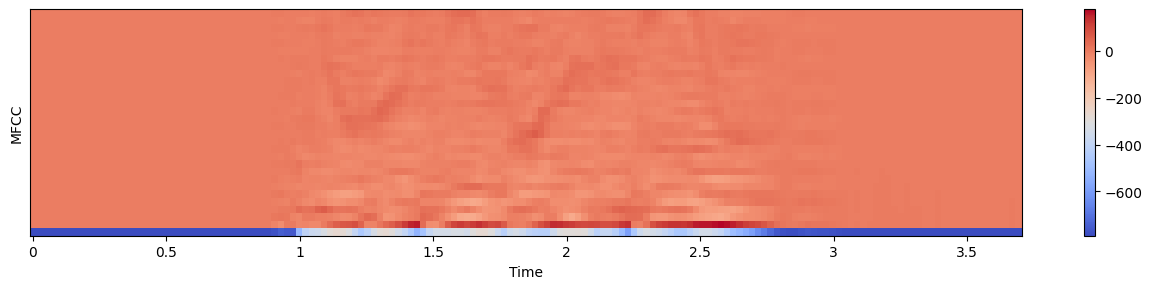

In [17]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)

# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(data,rate=sr)

In [18]:
data

array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        2.2835179e-08, -2.7907586e-08,  3.1686643e-08], dtype=float32)

In [19]:
def noise(data):
  noise_amp = 0.035*np.random.uniform()*np.amax(data)
  data = data + noise_amp*np.random.normal(size=data.shape[0])
  data = np.clip(data, -1.0, 1.0)
  return data

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

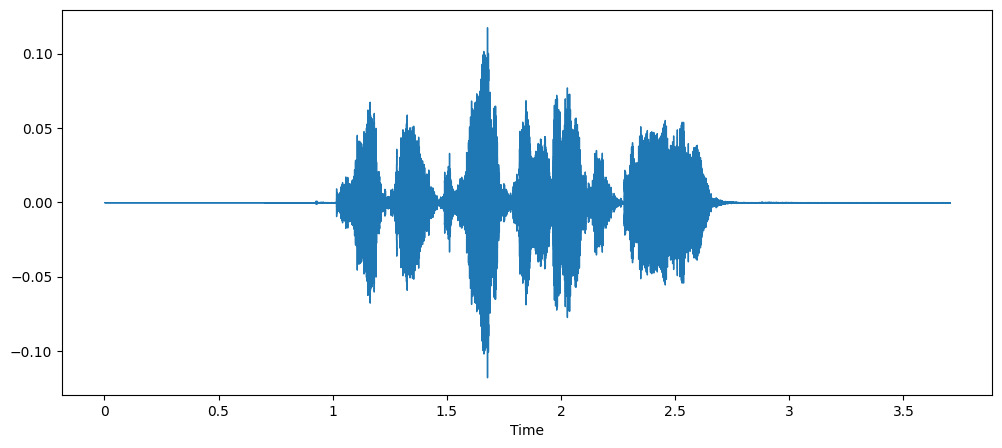

In [20]:
import librosa.display
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=data,sr=sr)
ipd.Audio(data,rate=sr)

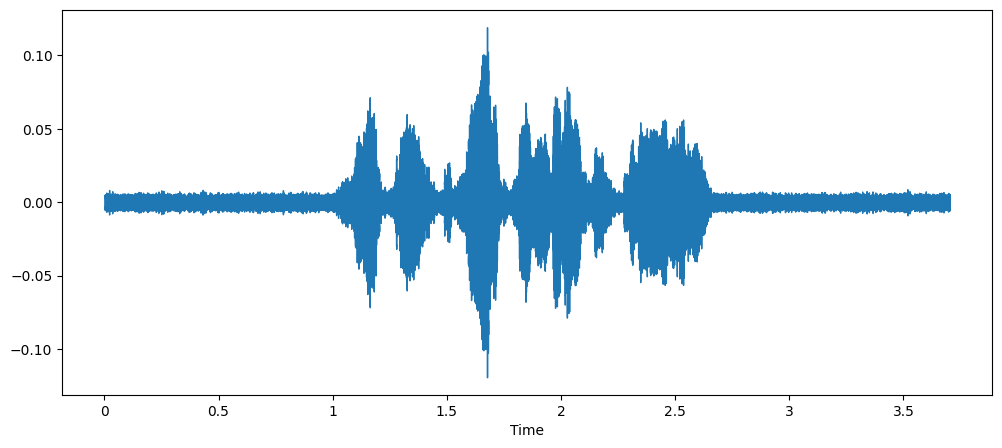

In [21]:
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x,sr=sr)
ipd.Audio(x,rate=sr)

In [22]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)

def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten=True):
    mfcc_result = librosa.feature.mfcc(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(mfcc_result.T) if not flatten else np.ravel(mfcc_result.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
  result=np.array([])

  result=np.hstack((result,
      zcr(data,frame_length,hop_length),
      rmse(data,frame_length,hop_length),
      mfcc(data,sr,frame_length,hop_length)
    ))

  return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)
    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))

    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))

    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))

    return audio


In [23]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  96


In [24]:
import timeit
from tqdm import tqdm

start = timeit.default_timer()
X,Y=[],[]
for path,emotion,index in tqdm (zip(Ravdess_df.Path,Ravdess_df.Emotions,range(data_path.Path.shape[0]))):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)

1it [00:03,  3.01s/it]

0 audio has been processed


501it [01:52,  4.57it/s]

500 audio has been processed


1001it [03:39,  4.64it/s]

1000 audio has been processed


1440it [05:15,  4.56it/s]

Done
Time:  315.978120989


In [25]:
len(X), len(Y), data_path.Path.shape

(5760, 5760, (1440,))

In [26]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.000000,0.000000,0.000000,0.009277,0.175293,0.323242,0.510254,0.637695,0.588867,0.645996,...,-0.057125,0.695113,0.697851,-0.092935,-0.240181,0.477084,0.654210,-0.117419,-0.503070,surprised
1,0.255371,0.381348,0.518066,0.520020,0.514160,0.523438,0.514160,0.512695,0.510742,0.506348,...,1.722669,-1.720584,-0.734735,-0.309023,2.388283,1.478841,-0.102438,-0.868135,-3.271058,surprised
2,0.000977,0.156250,0.299805,0.426270,0.556641,0.541504,0.530273,0.545898,0.563965,0.586914,...,-0.048991,0.112406,0.057266,-0.108190,-0.065231,0.103378,0.072841,-0.098026,-0.080058,surprised
3,0.257324,0.384277,0.513672,0.515137,0.505371,0.495117,0.486328,0.480957,0.479004,0.484863,...,0.727019,-1.832919,2.445176,2.755910,2.117402,-2.425786,1.660326,1.185090,-2.754218,surprised
4,0.220215,0.335449,0.450684,0.451172,0.480469,0.499023,0.521973,0.542480,0.546387,0.547363,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,fearful


In [27]:
Emotions = pd.read_csv('./emotion.csv')
Emotions

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.000000,0.000000,0.000000,0.009277,0.175293,0.323242,0.510254,0.637695,0.588867,0.645996,...,-0.057125,0.695113,0.697851,-0.092935,-0.240181,0.477084,0.654210,-0.117419,-0.503070,surprised
1,0.255371,0.381348,0.518066,0.520020,0.514160,0.523438,0.514160,0.512695,0.510742,0.506348,...,1.722669,-1.720584,-0.734735,-0.309023,2.388283,1.478841,-0.102438,-0.868135,-3.271058,surprised
2,0.000977,0.156250,0.299805,0.426270,0.556641,0.541504,0.530273,0.545898,0.563965,0.586914,...,-0.048991,0.112406,0.057266,-0.108190,-0.065231,0.103378,0.072841,-0.098026,-0.080058,surprised
3,0.257324,0.384277,0.513672,0.515137,0.505371,0.495117,0.486328,0.480957,0.479004,0.484863,...,0.727019,-1.832919,2.445176,2.755910,2.117402,-2.425786,1.660326,1.185090,-2.754218,surprised
4,0.220215,0.335449,0.450684,0.451172,0.480469,0.499023,0.521973,0.542480,0.546387,0.547363,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,fearful
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5755,0.242188,0.370117,0.500000,0.486816,0.476562,0.465332,0.459473,0.470215,0.485352,0.497070,...,-15.772653,-12.899549,0.431521,2.773774,-5.216503,-6.497118,-1.740381,-6.403401,-3.911044,surprised
5756,0.056641,0.067383,0.085449,0.109375,0.108398,0.124512,0.155273,0.151367,0.168457,0.206055,...,8.004860,9.438132,14.805857,14.373449,6.551937,0.857877,3.053296,6.685616,3.954738,happy
5757,0.086914,0.109375,0.176270,0.224609,0.221680,0.244629,0.263672,0.257324,0.288574,0.338379,...,4.892010,11.970191,12.928826,5.838980,2.244438,0.989332,6.087273,7.939836,1.553824,happy
5758,0.041992,0.043945,0.060059,0.081543,0.074219,0.098145,0.101562,0.083496,0.078125,0.066895,...,6.074419,9.864875,13.992591,9.499202,-0.057346,-3.954805,-0.866093,0.224262,-4.905458,happy


In [28]:
print(Emotions.isna().any())


0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


In [29]:
Emotions = Emotions.fillna(0)
print(Emotions.isna().any())

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


In [30]:
np.sum(Emotions.isna())

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


,0
0,0
1,0
2,0
3,0
4,0
...,...
2372,0
2373,0
2374,0
2375,0


In [33]:
X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [34]:
from sklearn.preprocessing import StandardScaler,OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [35]:
print(Y.shape)
X.shape

(5760, 8)


(5760, 2376)

In [37]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=42,shuffle=True)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((4608, 2376), (1152, 2376), (4608, 8), (1152, 8))

In [40]:
X_train = x_train.reshape(x_train.shape[0], x_train.shape[1],1)
X_test = x_test.reshape(x_test.shape[0], x_test.shape[1],1)


In [39]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4608, 2376, 1), (4608, 8), (1152, 2376, 1), (1152, 8))